In [21]:
import time
import datetime
import random
import gc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from transformers import BertTokenizer, DistilBertTokenizer
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch

##Helper Functions

In [22]:
def updating_interval(total_iterations, number_of_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    
    # Divide the total iterations by the desired number of updates.
    exact_interval = total_iterations / number_of_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_magntiude = len(str(total_iterations)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_magnitude = order_of_magntiude - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_magnitude))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

In [23]:
def show_time(elapsed_time):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_time_rounded = int(round((elapsed_time)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_time_rounded))

In [31]:
def extract_data(data):
    '''
    Extract text and labels in a list
    '''
    
    text = []
    labels=[]
    
    # Iterate over the data
    for idx, row in data.iterrows():
        # The text is a `bytes` object, decode to string.
        text.append(row['clean_text'])

        # Cast the label from `np.int64` to `int`
        labels.append(int(row['labels']))
        
    return text, labels

##Import data

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
train_data = pd.read_csv('/content/drive/MyDrive/NNDL_Datasets/IMDB_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/NNDL_Datasets/IMDB_test.csv')
val_data = pd.read_csv('/content/drive/MyDrive/NNDL_Datasets/IMDB_val.csv')

In [27]:
# For YELP data
#train_data = pd.read_csv('/content/drive/MyDrive/NNDL_Datasets/YELP_train.csv')
#test_data = pd.read_csv('/content/drive/MyDrive/NNDL_Datasets/YELP_test.csv')
#val_data = pd.read_csv('/content/drive/MyDrive/NNDL_Datasets/YELP_val.csv')
#train_data['labels'] = train_data['labels']-1
#test_data['labels'] = test_data['labels']-1
#val_data['labels'] = val_data['labels']-1

## Extract data and see the shape and labels

In [30]:
train_text, train_labels = extract_data(train_data)
test_text, test_labels = extract_data(test_data)
val_text, val_labels = extract_data(val_data)

# Print some stats.
print('{:,} Training Samples'.format(len(train_labels)))
print('{:,} Test Samples'.format(len(test_labels)))
print('{:,} Validation Samples'.format(len(val_labels)))
print('Labels:', np.unique(train_labels))

35,000 Training Samples
7,500 Test Samples
7,500 Validation Samples
Labels: [0 1]


## See few examples of review and label

In [32]:
for i,j in zip(train_text[:3], train_labels[:3]):
    print('Review:', i)
    print('Label:', j)
    print('-----------------')

Review: john garfield plays marine blinded grenade fighting guadalcanal learn live disability stereotypical notions blindness sure hell burden everyone hospital staff fellow wounded marines cant get neither girl back home played eleanor parker hes stubborn blinded fears self pity prejudices complex role garfield carries memorably great performance keeps one watching spite ever present syrupy melodrama best scenes guadalcanal hes machine gun nest trying fend advancing japanese soldiers hellish looking night time battle later dream sequence hospital sees walking train platform white cane dark glasses holding tin cup girlfriend walks backward away camera
Label: 1
-----------------
Review: saw anatomy years ago dubbed friends house dont remember much saw video store second one really related first one franka ponte makes little cameo one okay good first one im seeing first one tonight dubbed collectors edition really like german movies like one interesting people cults like one movie could 

## Check class distrubution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


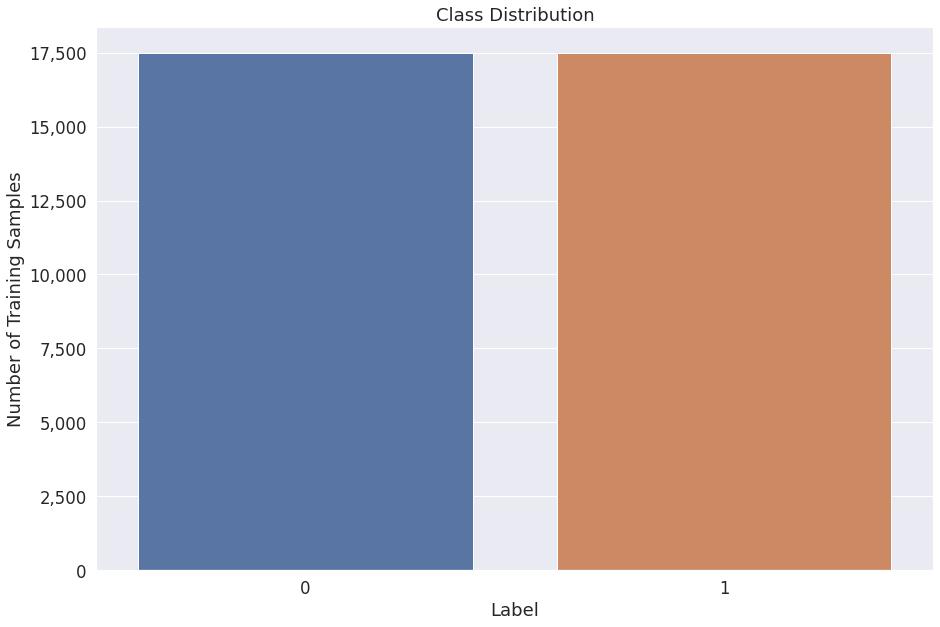

In [33]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (15,10)

# Plot the number of tokens of each length.
ax = sns.countplot(train_labels)

# Add labels
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Training Samples')

# Add thousands separators to the y-axis labels.
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

#Smart Batching

##Load Tokenizer

In [34]:
# Load the tokenizer.
print('Loading tokenizer...')

Loading tokenizer...


In [35]:
# For BERT model
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [36]:
# For DistilBERT model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

##Fixed Padding

In [37]:
fixed_padding = True

if fixed_padding:

    # Specify batch_size and truncation length.    
    batch_size = 16
    max_len = 400   

    # Tokenize all training examples
    print('Tokenizing {:,} training samples'.format(len(train_text)))

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    batches_of_input_ids = []
    batches_of_attention_masks = []
    batches_of_labels = []

    update_interval = batch_size * 150 

    # For every sequence
    for i in range(0, len(train_text), batch_size):

        if ((i % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(i))

        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.batch_encode_plus(
                            train_text[i:i+batch_size],     # Batch of sentences to encode.
                            add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                            max_length = 400,               # Pad & truncate all sentences.
                            padding = 'max_length',         # Pad all to the `max_length` parameter.
                            truncation = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',          # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        batches_of_input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        batches_of_attention_masks.append(encoded_dict['attention_mask'])

        # Add the labels for the batch
        batches_of_labels.append(torch.tensor(train_labels[i:i+batch_size]))
    
    # Rename the final variable to match the rest of the code in this Notebook.
    py_inputs = batches_of_input_ids
    py_attn_masks = batches_of_attention_masks
    py_labels = batches_of_labels

Tokenizing 35,000 training samples
  Tokenized 0 samples.
  Tokenized 2,400 samples.
  Tokenized 4,800 samples.
  Tokenized 7,200 samples.
  Tokenized 9,600 samples.
  Tokenized 12,000 samples.
  Tokenized 14,400 samples.
  Tokenized 16,800 samples.
  Tokenized 19,200 samples.
  Tokenized 21,600 samples.
  Tokenized 24,000 samples.
  Tokenized 26,400 samples.
  Tokenized 28,800 samples.
  Tokenized 31,200 samples.
  Tokenized 33,600 samples.


#Fine-tune Model

##Load Configuration and Model

In [38]:
# For BERT model

# Load the Config object, with an output configured for classification.
#config = AutoConfig.from_pretrained(pretrained_model_name_or_path='bert-base-uncased',
                                    #num_labels=2)

# Load the pre-trained model for classification, passing in the `config` from above.
#model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path='bert-base-uncased',
                                                           #config=config)

In [39]:
# For DistilBERT model

# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path='distilbert-base-uncased',
                                    num_labels=2)

# Load the pre-trained model for classification, passing in the `config` from above.
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path='distilbert-base-uncased',
                                                           config=config)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

In [40]:
# Collect garbage
torch.cuda.empty_cache()
gc.collect()

2831

In [41]:
print('Loading model to GPU')

device = torch.device('cuda')

print('--- GPU:', torch.cuda.get_device_name(0))

desc = model.to(device)

print('DONE.')

Loading model to GPU
--- GPU: Tesla K80
DONE.


## Setup the optimizer

In [42]:
# AdamW is a class from the huggingface library, 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # Got this value after hyper parameter optimization
                )

## Set up the scheduler

In [43]:
epochs = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

##Train the model

In [44]:
# This training code is based on the `run_glue.py` script of huggingface.

# Set the seed value all over the place to make this reproducible.
seed_val = 321

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = []

# Update every `update_interval` batches.
update_interval = updating_interval(total_iterations=len(py_inputs), number_of_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

epochs=1
# For each epoch...
for epoch_i in range(0, epochs):
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    
    # At the start of each epoch (except for the first) we need to re-randomize our training data.
    if epoch_i > 0:
        # Use our `make_smart_batches` function to re-shuffle the dataset into new batches.
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_text, train_labels, batch_size)
    
    print('Training on {:,} batches'.format(len(py_inputs)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. 
    model.train()

    # For each batch of training data.
    for step in range(0, len(py_inputs)):

        # Progress update every, e.g., 100 batches.
        if step % update_interval == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = show_time(time.time() - t0)
            
            # Calculate the time remaining based on our progress.
            steps_per_sec = (time.time() - t0) / step
            remaining_sec = steps_per_sec * (len(py_inputs) - step)

            # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.'.format(step, len(py_inputs), elapsed))

        # Copy the current training batch to the GPU using the `to` method.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels).values()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)            
    
    # Measure how long this epoch took.
    training_time = show_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(show_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training on 2,188 batches
  Batch     200  of    2,188.    Elapsed: 0:03:48.
  Batch     400  of    2,188.    Elapsed: 0:07:36.
  Batch     600  of    2,188.    Elapsed: 0:11:24.
  Batch     800  of    2,188.    Elapsed: 0:15:12.
  Batch   1,000  of    2,188.    Elapsed: 0:19:01.
  Batch   1,200  of    2,188.    Elapsed: 0:22:49.
  Batch   1,400  of    2,188.    Elapsed: 0:26:37.
  Batch   1,600  of    2,188.    Elapsed: 0:30:25.
  Batch   1,800  of    2,188.    Elapsed: 0:34:13.
  Batch   2,000  of    2,188.    Elapsed: 0:38:02.

  Average training loss: 0.29
  Training epcoh took: 0:41:36

Training complete!
Total training took 0:41:36 (h:mm:ss)


##Evaluating the model on test data

In [47]:
fixed_padding = True

if fixed_padding:

    # Specify batch_size and truncation length.    
    batch_size = 16
    max_len = 400   

    # Tokenize all training examples
    print('Tokenizing {:,} testing samples'.format(len(test_text)))

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    batches_of_input_ids = []
    batches_of_attention_masks = []
    batches_of_labels = []

    update_interval = batch_size * 150 

    # For every sequence
    for i in range(0, len(test_text), batch_size):

        if ((i % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(i))

        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.batch_encode_plus(
                            test_text[i:i+batch_size],     # Batch of sentences to encode.
                            add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                            max_length = 400,               # Pad & truncate all sentences.
                            padding = 'max_length',         # Pad all to the `max_length` parameter.
                            truncation = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',          # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        batches_of_input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        batches_of_attention_masks.append(encoded_dict['attention_mask'])

        # Add the labels for the batch
        batches_of_labels.append(torch.tensor(test_labels[i:i+batch_size]))
    
    # Rename the final variable to match the rest of the code in this Notebook.
    py_inputs = batches_of_input_ids
    py_attn_masks = batches_of_attention_masks
    py_labels = batches_of_labels

# Prediction on test set

print('Predicting labels for {:,} test sentences'.format(len(test_labels)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Choose an interval on which to print progress updates.
update_interval = updating_interval(total_iterations=len(py_inputs), number_of_desired_updates=10)

# Measure elapsed time.
t0 = time.time()

# For each batch of the data
for step in range(0, len(py_inputs)):

    # Progress update every 100 batches.
    if step % update_interval == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = show_time(time.time() - t0)

        # Report progress.
        print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.'.format(step, len(py_inputs), elapsed))

    # Copy the batch to the GPU.
    b_input_ids = py_inputs[step].to(device)
    b_input_mask = py_attn_masks[step].to(device)
    b_labels = py_labels[step].to(device)
  
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('DONE.')

# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Choose the label with the highest score as our prediction.
preds = np.argmax(predictions, axis=1).flatten()

# Calculate simple flat accuracy -- number correct over total number.
accuracy = (preds == true_labels).mean()

print('Accuracy: {:.3f}'.format(accuracy))

Tokenizing 7,500 testing samples
  Tokenized 0 samples.
  Tokenized 2,400 samples.
  Tokenized 4,800 samples.
  Tokenized 7,200 samples.
Predicting labels for 7,500 test sentences
  Batch      50  of      469.    Elapsed: 0:00:21.
  Batch     100  of      469.    Elapsed: 0:00:43.
  Batch     150  of      469.    Elapsed: 0:01:04.
  Batch     200  of      469.    Elapsed: 0:01:25.
  Batch     250  of      469.    Elapsed: 0:01:46.
  Batch     300  of      469.    Elapsed: 0:02:07.
  Batch     350  of      469.    Elapsed: 0:02:29.
  Batch     400  of      469.    Elapsed: 0:02:50.
  Batch     450  of      469.    Elapsed: 0:03:11.
DONE.
Accuracy: 0.912


##Evaluating the model on validation data

In [48]:
fixed_padding = True

if fixed_padding:

    # Specify batch_size and truncation length.    
    batch_size = 16
    max_len = 400   

    # Tokenize all training examples
    print('Tokenizing {:,} testing samples'.format(len(val_text)))

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    batches_of_input_ids = []
    batches_of_attention_masks = []
    batches_of_labels = []

    update_interval = batch_size * 150 

    # For every sequence
    for i in range(0, len(val_text), batch_size):

        if ((i % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(i))

        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.batch_encode_plus(
                            val_text[i:i+batch_size],     # Batch of sentences to encode.
                            add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                            max_length = 400,               # Pad & truncate all sentences.
                            padding = 'max_length',         # Pad all to the `max_length` parameter.
                            truncation = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',          # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        batches_of_input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        batches_of_attention_masks.append(encoded_dict['attention_mask'])

        # Add the labels for the batch
        batches_of_labels.append(torch.tensor(val_labels[i:i+batch_size]))
    
    # Rename the final variable to match the rest of the code in this Notebook.
    py_inputs = batches_of_input_ids
    py_attn_masks = batches_of_attention_masks
    py_labels = batches_of_labels

# Prediction on test set

print('Predicting labels for {:,} test sentences'.format(len(val_labels)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Choose an interval on which to print progress updates.
update_interval = updating_interval(total_iterations=len(py_inputs), number_of_desired_updates=10)

# Measure elapsed time.
t0 = time.time()

# For each batch of the data
for step in range(0, len(py_inputs)):

    # Progress update every 100 batches.
    if step % update_interval == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = show_time(time.time() - t0)

        # Report progress.
        print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.'.format(step, len(py_inputs), elapsed))

    # Copy the batch to the GPU.
    b_input_ids = py_inputs[step].to(device)
    b_input_mask = py_attn_masks[step].to(device)
    b_labels = py_labels[step].to(device)
  
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('DONE.')

# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Choose the label with the highest score as our prediction.
preds = np.argmax(predictions, axis=1).flatten()

# Calculate simple flat accuracy -- number correct over total number.
accuracy = (preds == true_labels).mean()

print('Accuracy: {:.3f}'.format(accuracy))

Tokenizing 7,500 testing samples
  Tokenized 0 samples.
  Tokenized 2,400 samples.
  Tokenized 4,800 samples.
  Tokenized 7,200 samples.
Predicting labels for 7,500 test sentences
  Batch      50  of      469.    Elapsed: 0:00:21.
  Batch     100  of      469.    Elapsed: 0:00:42.
  Batch     150  of      469.    Elapsed: 0:01:04.
  Batch     200  of      469.    Elapsed: 0:01:25.
  Batch     250  of      469.    Elapsed: 0:01:46.
  Batch     300  of      469.    Elapsed: 0:02:07.
  Batch     350  of      469.    Elapsed: 0:02:29.
  Batch     400  of      469.    Elapsed: 0:02:50.
  Batch     450  of      469.    Elapsed: 0:03:11.
DONE.
Accuracy: 0.910


## Count Parameters

In [49]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

66955010
